# Compressed Sensing MR - Dataset Creation

In this notebook we are going to extract random MR 2D slices for training to perform compressed sensing. In this illustration we extract patches using the [Calgary-Campinas-347](http://miclab.fee.unicamp.br/tools) public dataset. 

The goal of this tutorial is:
 - Illustrate how to create a 2D dataset using the coronal view. The dataset will be used for training a CNN for compressed sensing.
 
 In  order to execute this demo, you will have to update the paths in the code below accordingly.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import nibabel as nib
import os
import glob
import sys
import random
import time

In [2]:
patch_size = (256,256) 
npatches = 20 # number of slices per volume
offset = 8
#Adapt the following 3 paths accordingly
orig_path = "/media/roberto/DATA/GDrive/MR-Data/CC-359/Original/Original"
patches_path = "/media/roberto/DATA/CS-CC347"


cc347_list =np.genfromtxt("../Data/cc347_orig.txt", dtype ="string")
indexes = np.arange(cc347_list.shape[0],dtype = int)
np.random.shuffle(indexes)
cc347_list = cc347_list[indexes]
print cc347_list[0]

dataset = np.zeros((cc347_list.shape[0]*npatches,patch_size[0],patch_size[1]))

CC0234_siemens_3_57_M.nii.gz


In [3]:
counter = 0
for ii in cc347_list:
    orig_data = nib.load(os.path.join(orig_path,ii)).get_data()
    
    #Data normalization
    orig_min = orig_data.min()
    orig_max = orig_data.max()
    orig_data = 1000.0*(orig_data - orig_min)/(orig_max-orig_min)
    orig_data = orig_data.astype(np.uint16) # we save as uint16 to save space
    orig_data = orig_data[:,:patch_size[0],:patch_size[1]]
    
    H,W,Z = orig_data.shape
    
    #Randomly selecting nslices
    indexes = np.random.choice(np.arange(offset,H-offset,dtype = int),npatches,replace=False)
    dataset[counter*npatches:(counter+1)*npatches,:W,:Z] = orig_data[indexes]
    counter+=1    

## Displaying some of the samples

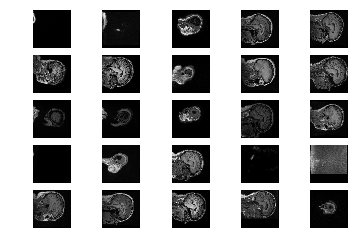

In [4]:
fig, ax = plt.subplots(nrows=5, ncols=5)
counter = 0
indexes = np.random.choice(dataset.shape[0],25,replace= False)
for row in ax:
    for col in row:
        col.imshow(dataset[indexes[counter]], cmap = 'gray')
        col.axis("off")
        counter+=1
plt.show()

In [5]:
np.save(os.path.join(patches_path,"cs_cc347_orig_uniform_25.npy"),dataset)

## Undersampling pattern - unidorm distribution

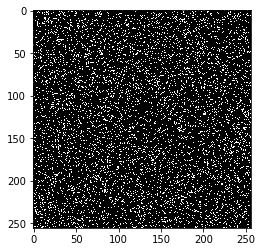

In [6]:
#Random sampling
undersampling_factor = int(0.25*patch_size[0]*patch_size[1]/2)

indexes = np.random.choice(np.arange(patch_size[0]*patch_size[1],dtype = int),undersampling_factor,replace=False)
indexesx = indexes/256
indexesy = indexes%256


under1 = np.zeros((patch_size[0],patch_size[1]),dtype = bool)
under1[indexesx,indexesy] = True
plt.figure()
plt.imshow(under1,cmap = "gray")
plt.show()

## Undersampling pattern - Gaussian distribution

(9258, 2)
8192


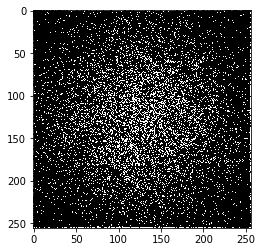

In [7]:
np.random.seed(int(time.time()))
samplesx = np.random.normal(0.5,0.25,int(1.3*undersampling_factor)) #1.8 is a factor to account for repeated samples
samplesx = np.clip(samplesx,0,1)
samplesy = np.random.normal(0.5,0.25,int(1.3*undersampling_factor))#1.8 is a factor to account for repeated samples
samplesy = np.clip(samplesy,0,1)

samplesx = np.round(samplesx*255).astype(int)
samplesy = np.round(samplesy*255).astype(int)
samples = np.concatenate((samplesx[:,np.newaxis],samplesy[:,np.newaxis]),axis =1)
x = np.random.rand(samples.shape[1])
y =samples.dot(x)
unique,index = np.unique(y,return_index=True)
samples = samples[index,:]
print samples.shape
print undersampling_factor
under = np.zeros((256,256),dtype = bool)
under[samples[:,0],samples[:,1]] = True
plt.figure()
plt.imshow(under,cmap = "gray")
plt.show()

## Undersampling k-space

In [8]:
dataset_rec = np.zeros((cc347_list.shape[0]*npatches,patch_size[0],patch_size[1]))
counter = 0
for ii in xrange(len(cc347_list)):
    fft_aux = np.fft.fft2(dataset[counter*npatches:(counter+1)*npatches])
    fft_aux[:,under1] = 0
    ifft_aux = np.abs(np.fft.ifft2(fft_aux))
    dataset_rec[counter*npatches:(counter+1)*npatches] = ifft_aux
    counter+=1    

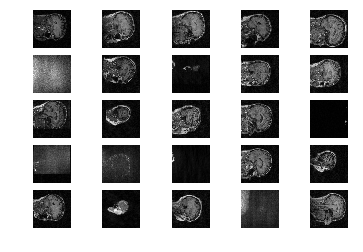

In [9]:
dataset_rec = np.abs(dataset_rec)
fig, ax = plt.subplots(nrows=5, ncols=5)
counter = 0
indexes = np.random.choice(dataset_rec.shape[0],25,replace= False)
for row in ax:
    for col in row:
        col.imshow(dataset_rec[indexes[counter]], cmap = 'gray')
        col.axis("off")
        counter+=1
plt.show()

In [10]:
np.save(os.path.join(patches_path,"cs_cc347_under_uniform_25.npy"),dataset_rec)
np.save(os.path.join(patches_path,"under_pattern_uniform_25.npy"),under1)